# Plotting Target Pixel Files with Lightkurve

## Learning Goals

By the end of this tutorial, you will:

- Learn how to download and plot target pixel files from the data archive using [Lightkurve](https://lightkurve.github.io/lightkurve/index.html).
- Be able to plot the target pixel file background.
- Be able to extract and plot flux from a target pixel file.


## Introduction

The [*Kepler*](https://www.nasa.gov/mission_pages/kepler/main/index.html), [*K2*](https://www.nasa.gov/mission_pages/kepler/main/index.html), and [*TESS*](https://tess.mit.edu/) telescopes observe stars for long periods of time, from just under a month to four years. By doing so they observe how the brightnesses of stars change over time.

Pixels around targeted stars are cut out and stored as *target pixel files* at each observing cadence. In this tutorial, we will learn how to use Lightkurve to download and understand the different photometric data stored in a target pixel file, and how to extract flux using basic aperture photometry.

It is useful to read the accompanying tutorial discussing how to use target pixel file products with Lightkurve before starting this tutorial. It is recommended that you also read the tutorial on using *Kepler* light curve products with Lightkurve, which will introduce you to some specifics on how *Kepler*, *K2*, and *TESS* make observations, and how these are displayed as light curves. It also introduces some important terms and concepts that are referred to in this tutorial.

*Kepler* observed a single field in the sky, although not all stars in this field were recorded. Instead, pixels were selected around certain targeted stars. These cutout images are called target pixel files, or TPFs. By  combining the amount of flux in the pixels where the star appears, you can make a measurement of the amount of light from a star in that observation. The pixels chosen to include in this measurement are referred to as an *aperture*.

TPFs are typically the first port of call when studying a star with *Kepler*, *K2*, or *TESS*. They allow us to see where our data is coming from, and identify potential sources of noise or systematic trends. In this tutorial, we will use the *Kepler* mission as the main example, but these tools equally apply to *TESS* and *K2* as well.

## Imports

This tutorial requires:
- **[Lightkurve](https://lightkurve.github.io/lightkurve/index.html)** to work with TPF files.
- [**Matplotlib**](https://matplotlib.org/) for plotting.

In [1]:
%matplotlib inline
from astropy import units as u
import lightkurve as lk
import matplotlib.pyplot as plt

## 1. Downloading a TPF

A TPF contains the original imaging data from which a light curve is derived. Besides the brightness data measured by the charge-coupled device (CCD) camera, a TPF also includes post-processing information such as an estimate of the astronomical background, and a recommended pixel aperture for extracting a light curve. 

First, we download a target pixel file. We will use one quarter's worth of *Kepler* data for the star named [Kepler-8](http://www.openexoplanetcatalogue.com/planet/Kepler-8%20b/), a star somewhat larger than the Sun, and the host of a [hot Jupiter planet](https://en.wikipedia.org/wiki/Hot_Jupiter). To search for TPF's that contain our object of interest we will use the [search_targetpixelfile](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_targetpixelfile.html) function as follows,

In [2]:
search_result = lk.search_targetpixelfile("Kepler-8", author="Kepler", quarter=4, cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0


In [3]:
tpf = search_result.download()

This TPF contains data for every cadence in the quarter we downloaded. Let's focus on the first cadence for now, which we can select using zero-based indexing as follows:

In [4]:
first_cadence = tpf[0]
first_cadence

KeplerTargetPixelFile Object (ID: 6922244)

## 2. Flux and Background

At each cadence the TPF has a number of photometry data properties. These are:

- `flux_bkg`: the astronomical background of the image.
- `flux_bkg_err`: the statistical uncertainty on the background flux.
- `flux`: the stellar flux after the background is removed.
- `flux_err`: the statistical uncertainty on the stellar flux after background removal.

These properties can be accessed via a TPF object as follows:

In [5]:
first_cadence.flux.value

array([[[          nan, 5.6079335e+00, 5.1491142e+01, 8.4241745e+01,
         3.0221334e+01],
        [4.4045620e+01, 7.6861229e+01, 1.1227759e+03, 3.2262029e+03,
         4.5486777e+02],
        [2.5911165e+01, 2.2907593e+02, 9.3626543e+03, 2.3606273e+04,
         1.2087750e+03],
        [4.0100830e+01, 8.8543927e+02, 1.7102118e+03, 2.6254871e+03,
         7.0796606e+02],
        [1.5719417e+02, 8.3713440e+02, 5.1021539e+02, 1.1501041e+03,
         1.8313370e+02]]], dtype='>f4')

And you can plot the data as follows:

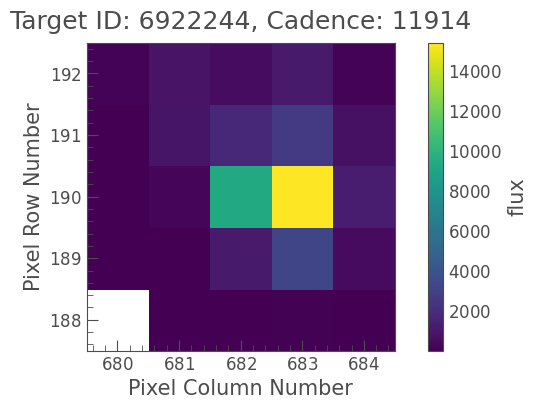

In [6]:
first_cadence.plot(column='flux');

Alternatively, if you are working directly with a FITS file, you can access the data in extension 1 (for example, `first_cadence.hdu[1].data['FLUX']`). Note that you can find all of the details on the structure and contents of TPF files in Section 2.3.2 of the [*Kepler* Archive Manual](http://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf) or Section 4.2 of the [TESS Data Products Description Document](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/active-missions/tess/_documents/EXP-TESS-ARC-ICD-TM-0014-Rev-F.pdf).

When plotting data using the `plot()` function, what you are by default seeing in the TPF is the flux *after* the background has been removed. This background flux typically consists of [zodiacal light](https://en.wikipedia.org/wiki/Zodiacal_light) or earthshine (especially in *TESS* observations). The background is typically smooth and changes on scales much larger than a single TPF. In *Kepler*, the background is estimated for the CCD as a whole, before being extracted from each TPF in that CCD. You can learn more about background removal in Section 4.2 of the [*Kepler* Data Processing Handbook](http://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-002-KDPH.pdf).

Now, let's compare the background to the background-subtracted flux to get a sense of scale. We can do this using the `plot()` function's `column` keyword. By default the function plots the flux, but we can change this to plot the background, as well as other data such as the error on each pixel's flux.

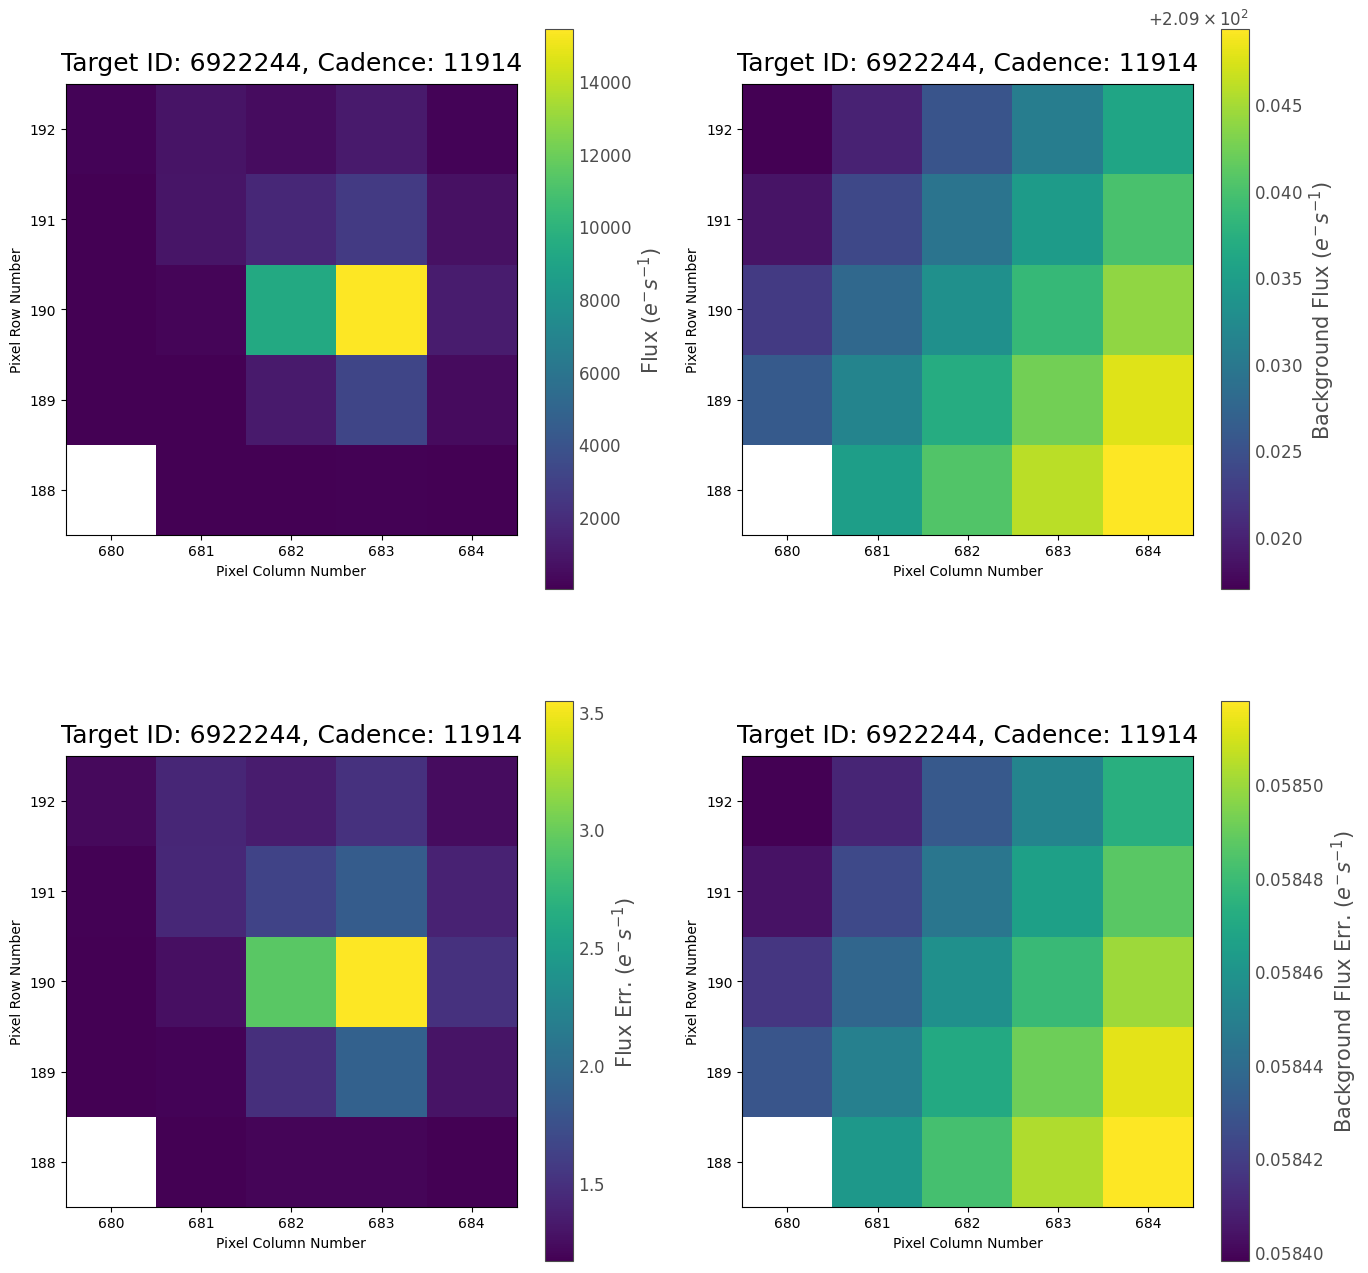

In [7]:
fig, axes = plt.subplots(2,2, figsize=(16,16))
first_cadence.plot(ax=axes[0,0], column='FLUX')
first_cadence.plot(ax=axes[0,1], column='FLUX_BKG')
first_cadence.plot(ax=axes[1,0], column='FLUX_ERR')
first_cadence.plot(ax=axes[1,1], column='FLUX_BKG_ERR');

From looking at the color scale on both plots, you may see that the background flux is very low compared to the total flux emitted by a star. This is expected — stars are bright! But these small background corrections become important when looking at the very small scale changes caused by planets or stellar oscillations. Understanding the background is an important part of astronomy with *Kepler*, *K2*, and *TESS*.

If the background is particularly bright and you want to see what the TPF looks like with it included, passing the `bkg=True` argument to the `plot()` method will show the TPF with the flux added on top of the background, representing the total flux recorded by the spacecraft.

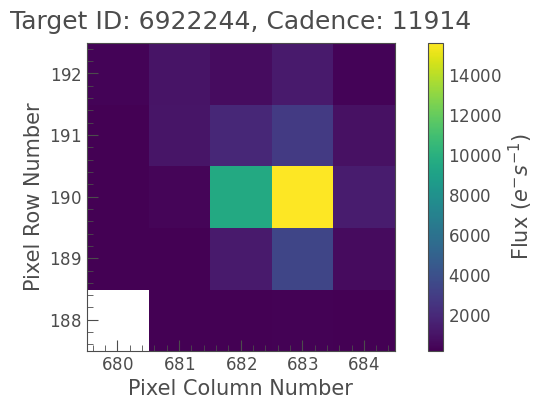

In [8]:
first_cadence.plot(bkg=True);

In this case, the background is low and the star is bright, so it doesn't appear to make much of a difference.

## 3. Apertures

As part of the data processing done by the *Kepler* pipeline, each TPF includes a recommended *optimal aperture mask*. This aperture mask is optimized to ensure that the stellar signal has a high signal-to-noise ratio, with minimal contamination from the background.

The optimal aperture is stored in the TPF as the [pipeline_mask](https://github.com/lightkurve/lightkurve/blob/eb9d3902bf3c2772aade6f4423cfa013394d5af8/src/lightkurve/targetpixelfile.py#L306) property. We can have a look at it by calling it here:

In [9]:
first_cadence.pipeline_mask

array([[False, False, False, False, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False,  True, False]])

As you can see, it is a Boolean array detailing which pixels are included. We can plot this aperture over the top of our TPF using the `plot()` function, and passing in the mask to the `aperture_mask` keyword. This will highlight the pixels included in the aperture mask using red hatched lines.

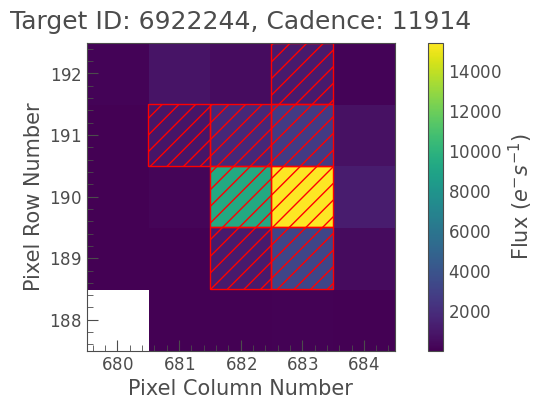

In [10]:
first_cadence.plot(aperture_mask=first_cadence.pipeline_mask);

You don't necessarily have to pass in the `pipeline_mask` to the `plot()` function; it can be any mask you create yourself, provided it is the right shape. An accompanying tutorial explains how to create such custom apertures, and goes into aperture photometry in more detail. For specifics on the selection of *Kepler*'s optimal apertures, read the [*Kepler* Data Processing Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19081-002-KDPH.pdf), Section 7, *Finding Optimal Apertures in Kepler Data*.

## 4. Simple Aperture Photometry

Finally, let's learn how to perform simple aperture photometry (SAP) using the provided optimal aperture in `pipeline_mask` and the TPF.

Using the full TPF for all cadences in the quarter, we can perform aperture photometry using the [to_lightcurve()](https://github.com/lightkurve/lightkurve/blob/eb9d3902bf3c2772aade6f4423cfa013394d5af8/src/lightkurve/targetpixelfile.py#L550) method as follows:

In [11]:
lc = tpf.to_lightcurve()

This method returns a `LightCurve` object which details the flux and flux centroid position at each cadence:

In [12]:
lc

time,flux,flux_err,centroid_col,centroid_row,cadenceno,quality
,electron / s,electron / s,pix,pix,,
Time,float32,float32,float64,float64,int32,int32
352.37632485035283,43689.1484375,6.631562232971191,682.6803253766153,190.0726135828141,11914,0
352.3967580484896,43698.078125,6.631830215454102,682.679939392134,190.0724388237138,11915,8192
352.4376244455707,43694.10546875,6.6317877769470215,682.6796255144184,190.07267575992847,11917,16
352.45805764463876,43698.31640625,6.631948947906494,682.6797879974883,190.07249571597706,11918,0
352.4784908439324,43687.6484375,6.631504535675049,682.6792868410989,190.07246464783114,11919,0
352.4989240434661,43686.4765625,6.6314263343811035,682.6797248240034,190.07284002730125,11920,0
...,...,...,...,...,...,...
442.1013323661464,43164.0703125,6.599811553955078,682.5025883479478,190.28110702349872,16305,0


Note that this `KeplerLightCurve` object has fewer data columns than in light curves downloaded directly from MAST. This is because we are extracting our light curve directly from the TPF using minimal processing, whereas light curves created using the official pipeline include more processing and more columns.

We can visualize the light curve as follows:

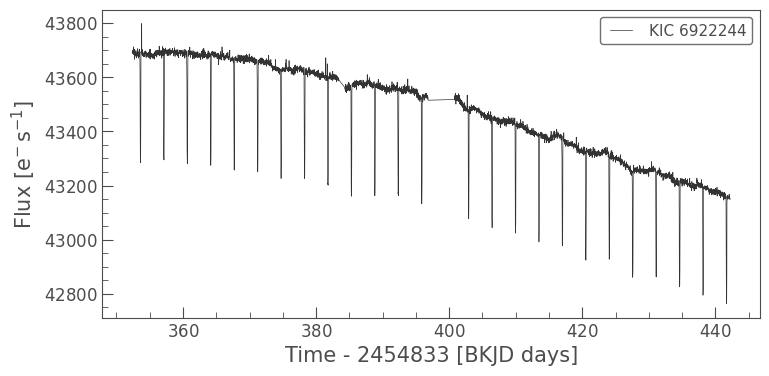

In [13]:
lc.plot();

This light curve is similar to the SAP light curve we previously encountered in the light curve tutorial.

### Note

The background flux can be plotted in a similar way, using the `get_bkg_lightcurve()` method. This does not require an aperture, but instead sums the flux in the TPF's `FLUX_BKG` column at each timestamp. 

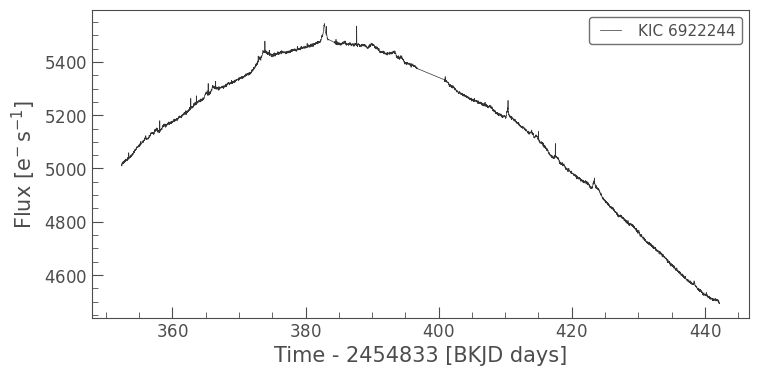

In [14]:
bkg = tpf.get_bkg_lightcurve()
bkg.plot();

Inspecting the background in this way is useful to identify signals which appear to be present in the background rather than in the astronomical object under study.

---

## Exercises

Some stars, such as the planet-hosting star Kepler-10, have been observed both with *Kepler* and *TESS*. In this exercise, download and plot both the *TESS* and *Kepler* TPFs, along with the optimal apertures. You can do this by either selecting the TPFs from the list returned by [search_targetpixelfile()](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_targetpixelfile.html), or by using the `mission` keyword argument when searching.

Both *Kepler* and *TESS* produce target pixel file data products, but these can look different across the two missions. *TESS* is focused on brighter stars and has larger pixels, so a star that might occupy many pixels in *Kepler* may only occupy a few in *TESS*.

How do light curves extracted from both of them compare?

In [15]:
#datalist = lk.search_targetpixelfile(...)


In [16]:
#soln:
datalist = lk.search_targetpixelfile("Kepler-10")
datalist

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 03,2009,Kepler,60,kplr011904151,0.0
1,Kepler Quarter 03,2009,Kepler,60,kplr011904151,0.0
2,Kepler Quarter 03,2009,Kepler,60,kplr011904151,0.0
3,Kepler Quarter 02,2009,Kepler,60,kplr011904151,0.0
4,Kepler Quarter 00,2009,Kepler,1800,kplr011904151,0.0
5,Kepler Quarter 01,2009,Kepler,1800,kplr011904151,0.0
...,...,...,...,...,...,...
66,TESS Sector 14,2019,TESS-SPOC,1800,377780790,0.0
67,TESS Sector 26,2020,TESS-SPOC,1800,377780790,0.0


In [17]:
kep = datalist[(datalist.author == "Kepler") & (datalist.exptime == 60*u.second)][0].download()
tes = datalist[(datalist.author == "SPOC") & (datalist.exptime == 120*u.second)][0].download()

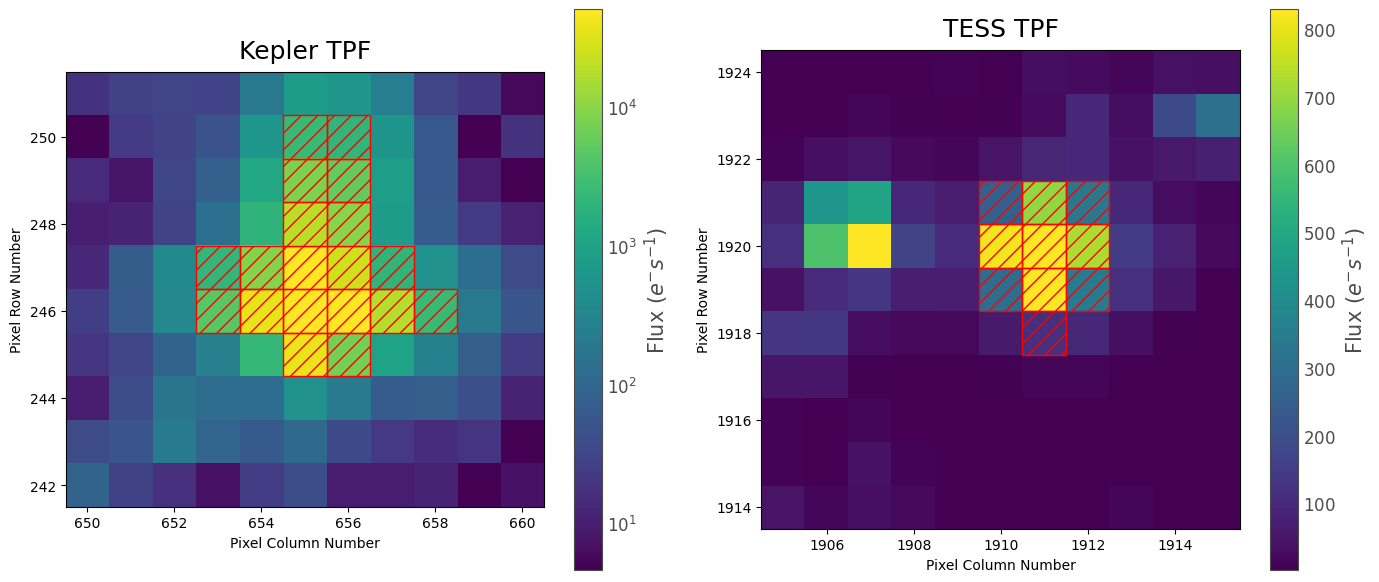

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
kep.plot(ax=axes[0], aperture_mask=kep.pipeline_mask, scale='log', title="Kepler TPF")
tes.plot(ax=axes[1], aperture_mask=tes.pipeline_mask, title="TESS TPF")
fig.tight_layout();

In [19]:
lc_kep = kep.to_lightcurve()
lc_tes = tes.to_lightcurve()

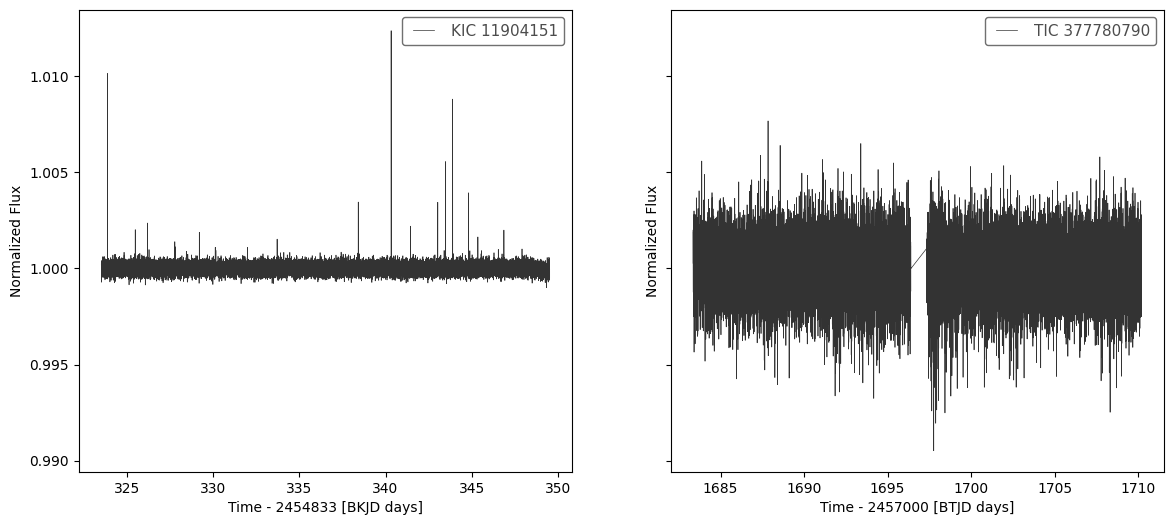

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
lc_kep.flatten().plot(ax=axes[0], c='k', alpha=.8)
lc_tes.flatten().plot(ax=axes[1], c='k', alpha=.8);

If you plot the light curves for both missions side by side, you will see a stark difference. The *Kepler* data has a much smaller scatter, and repeating transits are visible. This is because *Kepler*'s pixels were smaller, and so could achieve a higher precision on fainter stars. *TESS* has larger pixels and therefore focuses on brighter stars. For stars like Kepler-10, it would be hard to detect a planet using *TESS* data alone.

## About this Notebook

**Authors:** Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-15

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
